# 使用VAE來做手寫辨識，將最後的結果動態呈現出來，打造最好的呈現方式!
想想在encoder找到兩張手寫數字 a, b 的 latent representation，然後從代表 a 的 latent 到代表 b 的 latent 拉一直線, 把線段中代表的圖用 decoder 畫出來，這個必須是動態的圖片變化，可參考上禮拜上課呈現出來中間那張圖的樣子

In [75]:
%env KERAS_BACKEND=tensorflow
%matplotlib widget
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, Input, Lambda, concatenate, Conv2DTranspose, UpSampling2D
from keras import metrics
from keras.utils import np_utils, plot_model
from keras.optimizers import SGD, Adam
from keras import backend as k

env: KERAS_BACKEND=tensorflow


## Autoencoder
<img src="wk11_autoencoder.png" alt="drawing" style="width: 600px;"/>

## Variational Autoencoder
<img src="wk11_variational_autoencoder.png">

In [64]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()
#x_train = tf.image.per_image_standardization(x_train)
#x_test = tf.image.per_image_standardization(x_test)
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)
#y_train = np_utils.to_categorical(y_train, 10)
#y_test = np_utils.to_categorical(y_test, 10)
x_train -= x_train.min() ## 資料正規化
x_train = x_train/x_train.max() ## 資料正規化

## 架構及訓練模型

In [36]:
x = Input(shape=(784,))
enc_1 = Dense(100, activation='sigmoid')
enc_x = enc_1(x)
enc_mean = Dense(2)  # 均值
enc_var = Dense(2)  # 變異數
h_mean = enc_mean(enc_x)
h_var = enc_var(enc_x)

def sampling(args):
    h_mean, h_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return h_mean + K.exp(h_var / 2) * epsilon

h = Lambda(sampling, output_shape=(2,))([h_mean, h_var])

dec_2 = Dense(100, activation='sigmoid')
#dec_2_exec = dec_2
dec_1 = Dense(784, activation='sigmoid')

x_hat = dec_1(dec_2(h))

In [39]:
autoencodermodel = Model(x, x_hat)
plot_model(autoencodermodel, to_file='wk11_VAE_model.png', show_shapes=True)
autoencodermodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
dense_37 (Dense)                (None, 100)          78500       input_15[0][0]                   
__________________________________________________________________________________________________
dense_38 (Dense)                (None, 2)            202         dense_37[0][0]                   
__________________________________________________________________________________________________
dense_39 (Dense)                (None, 2)            202         dense_37[0][0]                   
__________________________________________________________________________________________________
lambda_7 (

<img src="wk11_VAE_model.png">

In [42]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + h_var - K.square(h_mean) - K.exp(h_var), axis=-1)
    return recovery_loss + kl_loss

autoencodermodel.compile(loss=vae_loss, optimizer=Adam())
autoencodermodel.fit(x_train, x_train, batch_size=1024, epochs=100)

Epoch 1/100
60000/60000 [==============================] - 4s 70us/step - loss: 331.1476
Epoch 2/100
60000/60000 [==============================] - 3s 50us/step - loss: 223.6473
Epoch 3/100
60000/60000 [==============================] - 3s 50us/step - loss: 210.3239
Epoch 4/100
60000/60000 [==============================] - 3s 48us/step - loss: 204.3211
Epoch 5/100
60000/60000 [==============================] - 3s 48us/step - loss: 200.6978
Epoch 6/100
60000/60000 [==============================] - 3s 53us/step - loss: 197.7751
Epoch 7/100
60000/60000 [==============================] - 3s 47us/step - loss: 196.5030
Epoch 8/100
60000/60000 [==============================] - 3s 48us/step - loss: 193.6314
Epoch 9/100
60000/60000 [==============================] - 3s 46us/step - loss: 190.7626
Epoch 10/100
60000/60000 [==============================] - 3s 46us/step - loss: 189.3101
Epoch 11/100
60000/60000 [==============================] - 3s 48us/step - loss: 187.7456
Epoch 12/100
60000/

In [44]:
VAE_Encoder = Model(x, h_mean)
VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [45]:
h_input = Input(shape=(2,))
#dec_1(dec_2(h_input))
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))
VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_40 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_41 (Dense)             (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


## VAE Encoder 視覺化

In [51]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 36254 圖的 latent 表示為 [[1.6209176  0.96268046]]


In [52]:
indices = np.random.randint(x_test.shape[0], size=1000)
VAE_latents = VAE_Encoder.predict(x_test[indices])

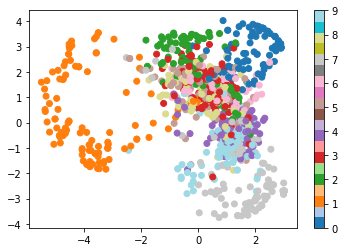

In [56]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test[indices], cmap='tab20')
plt.colorbar()
plt.show()
#結果沒有在0和1之間？

## VAE Decoder 視覺化

In [58]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

n = 15
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)



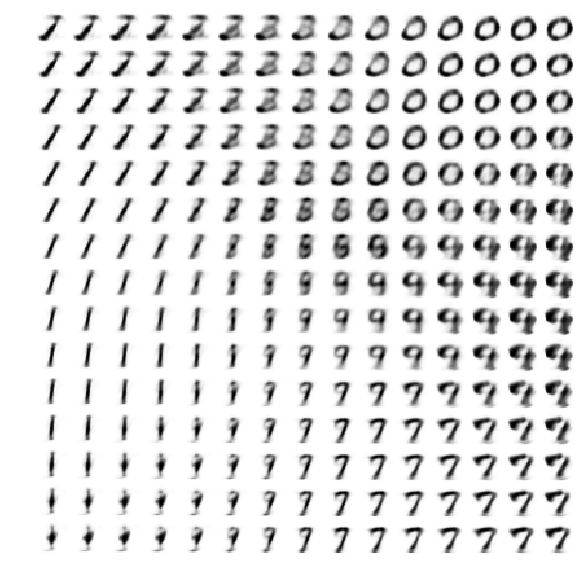

In [59]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

## VAE動態呈現

In [71]:
def inBetween(t, idx_1, idx_2):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Blues')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='autumn')

In [80]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
#data_0 = x_train0[idx_1]
#data_1 = x_train0[idx_2]
#inBetween(30)
s = FloatSlider(value=0.5, min=0, max=1.0, step=0.02)
idx_1_s = widgets.IntSlider(value=5, min=1, max=1000, description="idx_1")
idx_2_s = widgets.IntSlider(value=5, min=1, max=1000, description="idx_2")
#interact(inBetween,)
plot = widgets.interactive(inBetween, t=s, idx_1=idx_1_s, idx_2=idx_2_s)
pannel = [plot.children[0],plot.children[1]]
widgets.VBox(pannel)

In [63]:
def f(x):
    return(x)
interact(f,x=10)

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

<function __main__.f(x)>